In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import os
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def sentiment_analyzer(sentence):

    sentiment_object = SentimentIntensityAnalyzer()

    sentiment_dict = sentiment_object.polarity_scores(sentence)

    if sentiment_dict['compound'] >= 0.05:
        sentiment = 1
    elif sentiment_dict['compound'] <= -0.05:
        sentiment = -1
    else:
        sentiment = 0
    
    return sentiment

In [11]:
albums = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", 
          "Red (Taylor's Version)", "1989 (Taylor's Version)", "reputation", "Lover", 
          "folklore", "evermore", "Midnights", "The Tortured Poets Department"]

shortenings = ["Debut", "Fearless", "Speak Now", 
          "Red", "1989", "rep", "Lover", 
          "folklore", "evermore", "Midnights", "TTPD"]

In [12]:
if __name__ == "__main__":

    sentiment_class = {}
    # Iterates over all of the directories
    for root, dirs, files in os.walk('songs_excl_ftv', topdown=True):

        for dir in dirs:
            sentiment_class[dir] = {}
            for file in os.listdir(os.path.join("songs_excl_ftv/", dir)):
                title = os.path.join(f"songs_excl_ftv/{dir}", file)
                with open(title) as t:
                    sentiment_class[dir][file[0:file.index(".")]] = {}
                    content = t.read()
                    sentiment = sentiment_analyzer(content)
                    sentiment_class[dir][file[0:file.index(".")]] = sentiment

    positives = []
    negatives = []
    neutrals = []
    for album in albums:
        pos_counts = 0
        neg_counts = 0
        neut_counts = 0
        for song in sentiment_class[album]:
            if sentiment_class[album][song] == 1:
                pos_counts += 1
            elif sentiment_class[album][song] == -1:
                neg_counts += 1
            else:
                neut_counts += 1
        positives.append(pos_counts)
        negatives.append(neg_counts)
        neutrals.append(neut_counts)
        


In [14]:
num_of_songs = [14, 20, 16, 20, 17, 15, 19, 17, 17, 22, 31]

negatives = list(negatives)
neutrals = list(neutrals)
positives = list(positives)

for i, neg in enumerate(negatives):
    negatives[i] = neg / num_of_songs[i]

for i, pos in enumerate(positives):
    positives[i] = pos / num_of_songs[i]

negatives = np.array(negatives)
positives = np.array(positives)



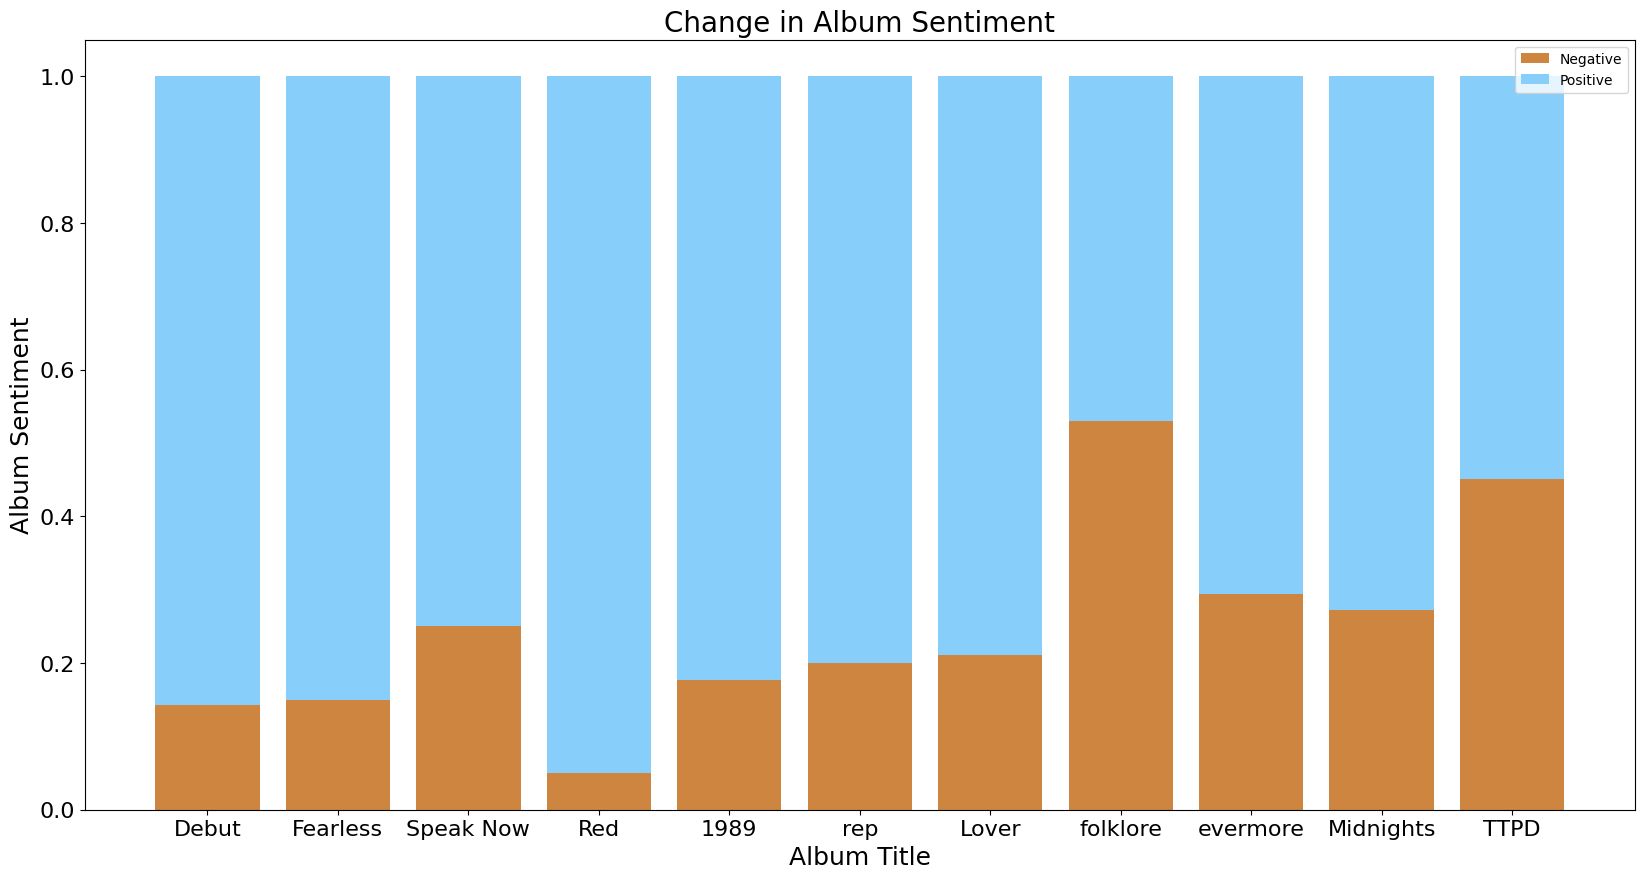

In [16]:
plt.figure(figsize=(20, 10))

plt.bar(shortenings, negatives, color='peru', label='Negative')
plt.bar(shortenings, positives, bottom = negatives, color='lightskyblue', label="Positive")

plt.tick_params(axis="both", which='major', labelsize="16")

plt.title("Change in Album Sentiment", fontsize='20')
plt.xlabel("Album Title", fontsize='18')
plt.ylabel("Album Sentiment", fontsize='18')

plt.legend()
plt.show()